In [1]:
import sys
sys.path.append('../util')
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ML_MJO_util as mjo 
import pickle
import pandas as pd 
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures

%load_ext autoreload
%autoreload 2

In [2]:
mjo_ind = 'RMM'
mjo_ind = 'ROMI'

In [3]:
def get_skill_one(mjo_ind='RMM', lead=0, cut_m=10, cut_k=9,cut_m_flg='resi', cut_k_flg='resi', exp_num="",
                  dir_path = '/pscratch/sd/l/linyaoly/ERA5/Unet4MJO/1map_MCDO_ERA5_yproj_xfft_4gpus_new/distillation/'):

    dataflg = f'_mcut{cut_m}kcut{cut_k}_{cut_m_flg}{cut_k_flg}_exp{exp_num}'
    fn = 'flt_input_predicted_MCDO_UNET_olr20deg_'+mjo_ind+'ERA5_1modesoff_wnx1off_lead'+str(lead)+dataflg+'.nc'

    # print('fn is: ', fn)
        
    ds = xr.open_dataset(dir_path+fn)
    datesta = ds.time[0].values
    dateend = ds.time[-1].values
    _, amp = mjo.get_phase_amp(mjo_ind, datesta, dateend)
    # ds['iphase'] = xr.DataArray(phase, dims=['time'], attrs={'long_name': 'initial phase of MJO'})
    ds['iamp'] = xr.DataArray(amp, dims=['time'], attrs={'long_name': 'initial amplitude of MJO'})
    ds_sel = ds.where(ds.iamp>1.0, drop=True)

    bcc = mjo.bulk_bcc(ds_sel[mjo_ind+'p'], ds_sel[mjo_ind+'t'])
    rmse = mjo.bulk_rmse(ds_sel[mjo_ind+'p'], ds_sel[mjo_ind+'t'])

    return bcc, rmse

def compute_get_skill_one(mjo_ind='RMM', lead=0, cut_m=10, cut_k=9, MD='E2', exp_num="",
                  dir_path = '/pscratch/sd/l/linyaoly/ERA5/Unet4MJO/1map_MCDO_ERA5_yproj_xfft_4gpus_new/distillation/'):
    if MD == 'E4':
        cut_k_flg = 'resi' 
        cut_m_flg = 'resi'
    elif MD == 'E3':
        cut_k_flg = 'all' 
        cut_m_flg = 'all'
    elif MD == 'E2':
        cut_k_flg = 'off' 
        cut_m_flg = 'all'
        cut_k = 1
            
    bcc, rmse = get_skill_one(mjo_ind, lead, cut_m, cut_k, cut_m_flg, cut_k_flg, exp_num, dir_path)
    
    return (lead, exp_num, MD), {'bcc':bcc, 'rmse':rmse}

def get_skill_parallel(mjo_ind='RMM', lead_list=np.arange(0,35,5), cut_m=10, cut_k=9, MD_list=['E2','E3','E4'], exp_num_list=["",], 
                  dir_path = '/pscratch/sd/l/linyaoly/ERA5/Unet4MJO/1map_MCDO_ERA5_yproj_xfft_4gpus_new/distillation/'):
    bcc_list = {}
    rmse_list = {}

    with ProcessPoolExecutor() as executor:

        future_to_skill = {executor.submit(compute_get_skill_one, mjo_ind, lead, cut_m, cut_k, MD, exp_num): 
                        (lead, exp_num, MD) for lead in lead_list for MD in MD_list for exp_num in exp_num_list}
        for future in concurrent.futures.as_completed(future_to_skill):
            key, skill = future.result()
            bcc_list[key] = skill['bcc']
            rmse_list[key] = skill['rmse']

    return bcc_list, rmse_list

In [4]:
dataflg = ''
rule = 'Iamp>1.0'
vn='19maps'
lead_list = [0,5,10,15,20,25,30]
exp_num_list = ['', '1', '2', '3','4', '5', '6', '7', '8', '9', '10']

bcc_list, rmse_list = mjo.get_19var_skill_parallel(mjo_ind, lead_list=lead_list, exp_num_list=exp_num_list, dataflg=dataflg, rule=rule, vn=vn)
bcc_19var = np.empty((len(exp_num_list), len(lead_list)))
rmse_19var = np.empty((len(exp_num_list), len(lead_list)))

for i, exp in enumerate(exp_num_list):
    for j, lead in enumerate(lead_list):
        bcc_19var[i,j] = bcc_list[(lead, exp)]
        rmse_19var[i,j] = rmse_list[(lead, exp)]


In [5]:
lead_list = np.arange(0, 35, 5)
cut_m = 10
cut_k = 9
exp_num_list = ['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
bcc_list, rmse_list = get_skill_parallel(mjo_ind, lead_list, cut_m, cut_k, ['E2', 'E3', 'E4'], exp_num_list)

In [6]:
vn = 'olr'
mflg = 'off'
wnx = 1
wnxflg = 'off'
m = 1
dataflg = ''
lead_list = [0,5,10,15,20,25,30]
exp_num_list = ['', '1', '2', '3','4', '5', '6', '7', '8', '9', '10']

bccref, rmseref = mjo.get_1var_skill_parallel(mjo_ind, lead_list=lead_list, exp_num_list=exp_num_list, m=m, mflg=mflg, wnx=wnx, wnxflg=wnxflg, dataflg=dataflg, vn=vn, zero_channel=False)

bccE1 = np.empty((len(exp_num_list), len(lead_list)))
rmseE1 = np.empty((len(exp_num_list), len(lead_list)))

for i, exp in enumerate(exp_num_list):
    for j, lead in enumerate(lead_list):
        bccE1[i,j] = bccref[(lead, exp)]
        rmseE1[i,j] = rmseref[(lead, exp)]


In [7]:
def plot_uncertainty_all(ax, x, y, ydis, line_c='tab:blue',alpha=1.0, style='-', alpha_fill=0.5):
    ax.plot(x, y, linestyle=style, linewidth=2.5, color=line_c, alpha=alpha)
    ax.fill_between(x, np.min(ydis, axis=1), np.max(ydis, axis=1), alpha=alpha_fill, color=line_c)
    

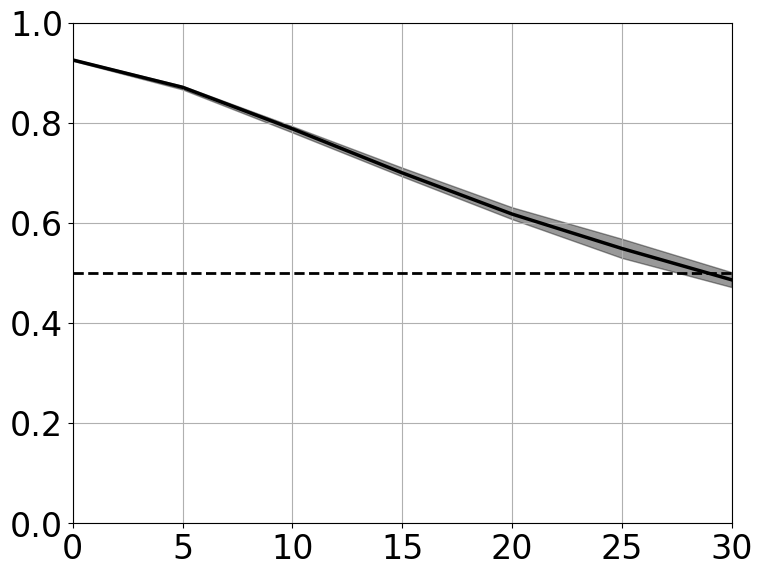

In [8]:
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(1, 1, figsize=(8.5, 6.5))

plot_uncertainty_all(ax, lead_list, np.mean(bcc_19var, axis=0), bcc_19var.T, line_c='black', alpha_fill=0.4)

# plot_uncertainty_all(ax, lead_list, np.mean(bccE1, axis=0), bccE1.T, line_c='#015482')

# line_color = ['tab:red', 'orange', '#9dbcd4']
# i = 0
# for MD in ['E2', 'E3', 'E4']:
#     bcc = np.array([bcc_list[(lead, exp_num, MD)] for lead in lead_list for exp_num in exp_num_list]).reshape(len(lead_list), len(exp_num_list))
#     # print(bcc.shape)
#     plot_uncertainty_all(ax, lead_list, np.mean(bcc, axis=1), bcc, line_c=line_color[i])
#     i += 1

xlim = [0, 30]
ylim = [0, 1.0]
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_xticks(np.arange(0, 31, 5))
ax.grid(visible=True)
ax.plot(xlim, [0.5, 0.5], 'k--', linewidth=2)
ax.set_yticks(np.arange(ylim[0], ylim[1]+0.1, 0.2))


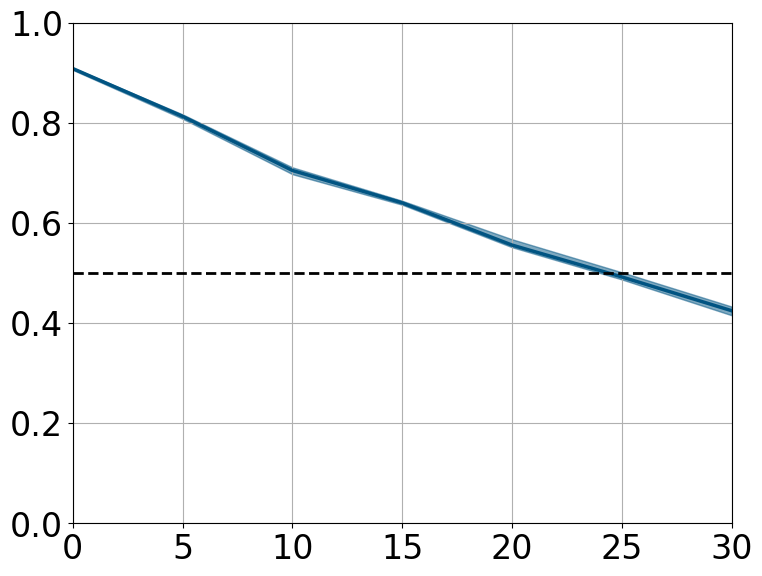

In [9]:
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(1, 1, figsize=(8.5, 6.5))

# plot_uncertainty_all(ax, lead_list, np.mean(bcc_19var, axis=0), bcc_19var.T, line_c='black', alpha_fill=0.4)

plot_uncertainty_all(ax, lead_list, np.mean(bccE1, axis=0), bccE1.T, line_c='#015482')

# line_color = ['tab:red', 'orange', '#9dbcd4']
# i = 0
# for MD in ['E2', 'E3', 'E4']:
#     bcc = np.array([bcc_list[(lead, exp_num, MD)] for lead in lead_list for exp_num in exp_num_list]).reshape(len(lead_list), len(exp_num_list))
#     # print(bcc.shape)
#     plot_uncertainty_all(ax, lead_list, np.mean(bcc, axis=1), bcc, line_c=line_color[i])
#     i += 1

xlim = [0, 30]
ylim = [0, 1.0]
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_xticks(np.arange(0, 31, 5))
ax.grid(visible=True)
ax.plot(xlim, [0.5, 0.5], 'k--', linewidth=2)
ax.set_yticks(np.arange(ylim[0], ylim[1]+0.1, 0.2))


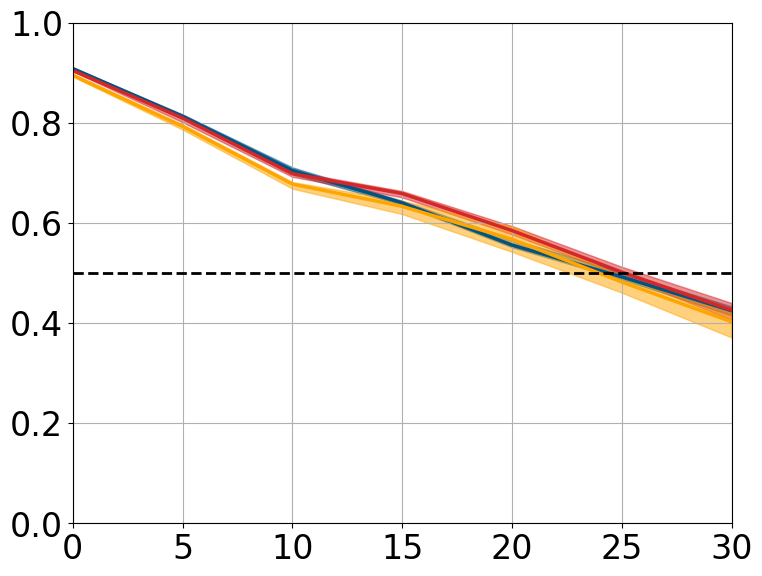

In [10]:
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(1, 1, figsize=(8.5, 6.5))

# plot_uncertainty_all(ax, lead_list, np.mean(bcc_19var, axis=0), bcc_19var.T, line_c='black', alpha_fill=0.4)

plot_uncertainty_all(ax, lead_list, np.mean(bccE1, axis=0), bccE1.T, line_c='#015482')

line_color = ['tab:red', 'orange', '#9dbcd4']
i = 0
for MD in ['E2', 'E3']:
    bcc = np.array([bcc_list[(lead, exp_num, MD)] for lead in lead_list for exp_num in exp_num_list]).reshape(len(lead_list), len(exp_num_list))
    # print(bcc.shape)
    plot_uncertainty_all(ax, lead_list, np.mean(bcc, axis=1), bcc, line_c=line_color[i])
    i += 1

xlim = [0, 30]
ylim = [0, 1.0]
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_xticks(np.arange(0, 31, 5))
ax.grid(visible=True)
ax.plot(xlim, [0.5, 0.5], 'k--', linewidth=2)
ax.set_yticks(np.arange(ylim[0], ylim[1]+0.1, 0.2))


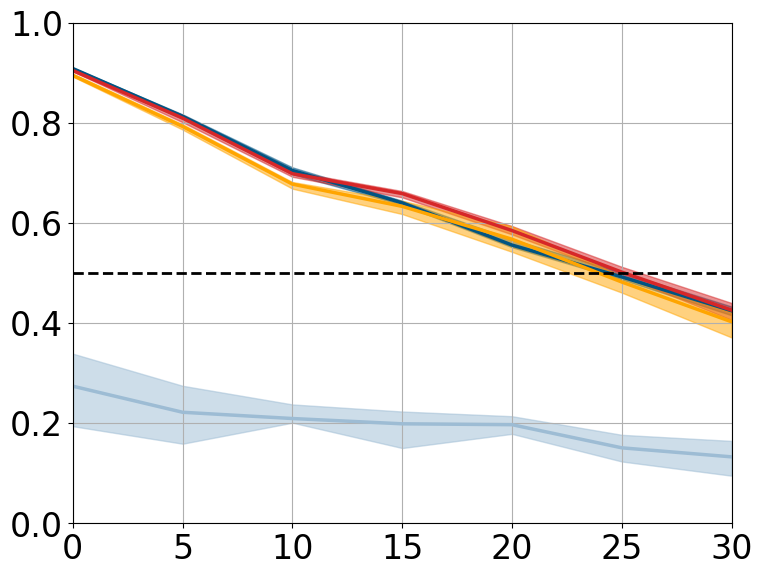

In [11]:
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(1, 1, figsize=(8.5, 6.5))

# plot_uncertainty_all(ax, lead_list, np.mean(bcc_19var, axis=0), bcc_19var.T, line_c='black', alpha_fill=0.4)

plot_uncertainty_all(ax, lead_list, np.mean(bccE1, axis=0), bccE1.T, line_c='#015482')

line_color = ['tab:red', 'orange', '#9dbcd4']
i = 0
for MD in ['E2', 'E3', 'E4']:
    bcc = np.array([bcc_list[(lead, exp_num, MD)] for lead in lead_list for exp_num in exp_num_list]).reshape(len(lead_list), len(exp_num_list))
    # print(bcc.shape)
    plot_uncertainty_all(ax, lead_list, np.mean(bcc, axis=1), bcc, line_c=line_color[i])
    i += 1

xlim = [0, 30]
ylim = [0, 1.0]
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_xticks(np.arange(0, 31, 5))
ax.grid(visible=True)
ax.plot(xlim, [0.5, 0.5], 'k--', linewidth=2)
ax.set_yticks(np.arange(ylim[0], ylim[1]+0.1, 0.2))


In [8]:
bcc_1var_fn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/bcc_all.pkl'

with open(bcc_1var_fn, 'rb') as f1:
    bcc_all = pickle.load(f1)

# bcc_all.keys()

rmse_1var_fn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/rmse_all.pkl'

with open(rmse_1var_fn, 'rb') as f:
    rmse_all = pickle.load(f)

# bcc_all.keys()


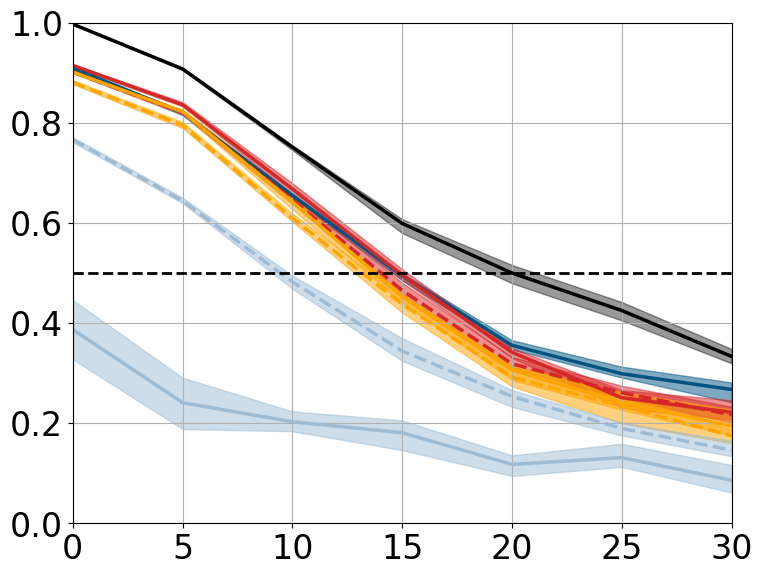

In [11]:
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(1, 1, figsize=(8.5, 6.5))

plot_uncertainty_all(ax, lead_list, np.mean(bcc_19var, axis=0), bcc_19var.T, line_c='black', alpha_fill=0.4)

plot_uncertainty_all(ax, lead_list, np.mean(bccE1, axis=0), bccE1.T, line_c='#015482')

line_color = ['tab:red', 'orange', '#9dbcd4']

if mjo_ind == 'RMM':
    exp_retrain = ['bcc_rmm_1var_10all1off','bcc_rmm_1var_10all9all','bcc_rmm_1var_10resi9resi']
elif mjo_ind == 'ROMI':
    exp_retrain = ['bcc_romi_1var_10all1off','bcc_romi_1var_10all9all','bcc_romi_1var_10resi9resi']

i = 0
for MD in ['E2', 'E3', 'E4']:
    bcc = np.array([bcc_list[(lead, exp_num, MD)] for lead in lead_list for exp_num in exp_num_list]).reshape(len(lead_list), len(exp_num_list))
    # print(bcc.shape)
    plot_uncertainty_all(ax, lead_list, np.mean(bcc, axis=1), bcc, line_c=line_color[i])

    data = bcc_all[exp_retrain[i]]
    plot_uncertainty_all(ax, lead_list, np.mean(data, axis=0), data.T, line_c=line_color[i], style='--')

    i += 1

xlim = [0, 30]
ylim = [0, 1.0]
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_xticks(np.arange(0, 31, 5))
ax.grid(visible=True)
ax.plot(xlim, [0.5, 0.5], 'k--', linewidth=2)
ax.set_yticks(np.arange(ylim[0], ylim[1]+0.1, 0.2))


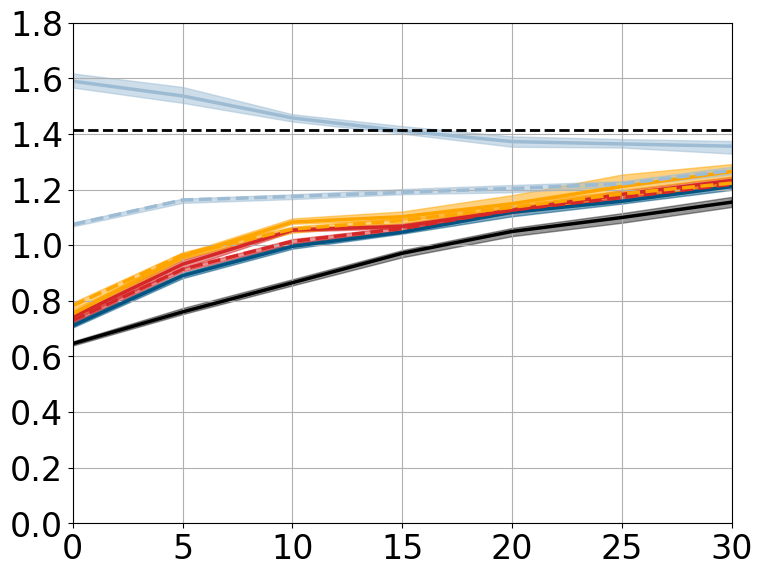

In [9]:
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(1, 1, figsize=(8.5, 6.5))

plot_uncertainty_all(ax, lead_list, np.mean(rmse_19var, axis=0), rmse_19var.T, line_c='black', alpha_fill=0.4)

plot_uncertainty_all(ax, lead_list, np.mean(rmseE1, axis=0), rmseE1.T, line_c='#015482')

line_color = ['tab:red', 'orange', '#9dbcd4']

if mjo_ind == 'RMM':
    exp_retrain = ['rmse_rmm_1var_10all1off','rmse_rmm_1var_10all9all','rmse_rmm_1var_10resi9resi']
elif mjo_ind == 'ROMI':
    exp_retrain = ['rmse_romi_1var_10all1off','rmse_romi_1var_10all9all','rmse_romi_1var_10resi9resi']

i = 0
for MD in ['E2', 'E3', 'E4']:
    rmse = np.array([rmse_list[(lead, exp_num, MD)] for lead in lead_list for exp_num in exp_num_list]).reshape(len(lead_list), len(exp_num_list))
    # print(bcc.shape)
    plot_uncertainty_all(ax, lead_list, np.mean(rmse, axis=1), rmse, line_c=line_color[i])

    data = rmse_all[exp_retrain[i]]
    plot_uncertainty_all(ax, lead_list, np.mean(data, axis=0), data.T, line_c=line_color[i], style='--')

    i += 1

xlim = [0, 30]
ylim = [0, 1.8]
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_xticks(np.arange(0, 31, 5))
ax.grid(visible=True)
ax.plot(xlim, [np.sqrt(2), np.sqrt(2)], 'k--', linewidth=2)
ax.set_yticks(np.arange(ylim[0], ylim[1]+0.1, 0.2))


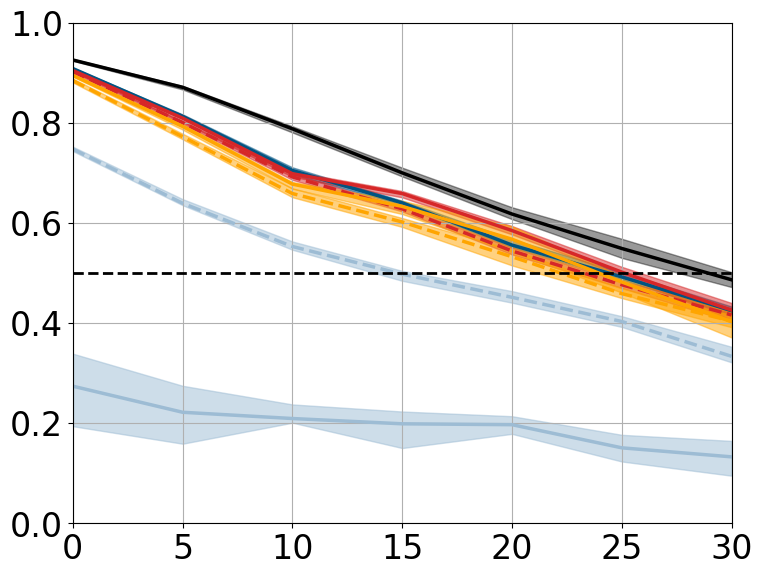

In [15]:
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(1, 1, figsize=(8.5, 6.5))

plot_uncertainty_all(ax, lead_list, np.mean(bcc_19var, axis=0), bcc_19var.T, line_c='black', alpha_fill=0.4)

plot_uncertainty_all(ax, lead_list, np.mean(bccE1, axis=0), bccE1.T, line_c='#015482')

line_color = ['tab:red', 'orange', '#9dbcd4']

if mjo_ind == 'RMM':
    exp_retrain = ['bcc_rmm_1var_10all1off','bcc_rmm_1var_10all9all','bcc_rmm_1var_10resi9resi']
elif mjo_ind == 'ROMI':
    exp_retrain = ['bcc_romi_1var_10all1off','bcc_romi_1var_10all9all','bcc_romi_1var_10resi9resi']

i = 0
for MD in ['E2', 'E3', 'E4']:
    bcc = np.array([bcc_list[(lead, exp_num, MD)] for lead in lead_list for exp_num in exp_num_list]).reshape(len(lead_list), len(exp_num_list))
    # print(bcc.shape)
    plot_uncertainty_all(ax, lead_list, np.mean(bcc, axis=1), bcc, line_c=line_color[i])

    data = bcc_all[exp_retrain[i]]
    plot_uncertainty_all(ax, lead_list, np.mean(data, axis=0), data.T, line_c=line_color[i], style='--')

    i += 1

xlim = [0, 30]
ylim = [0, 1.0]
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_xticks(np.arange(0, 31, 5))
ax.grid(visible=True)
ax.plot(xlim, [0.5, 0.5], 'k--', linewidth=2)
ax.set_yticks(np.arange(ylim[0], ylim[1]+0.1, 0.2))


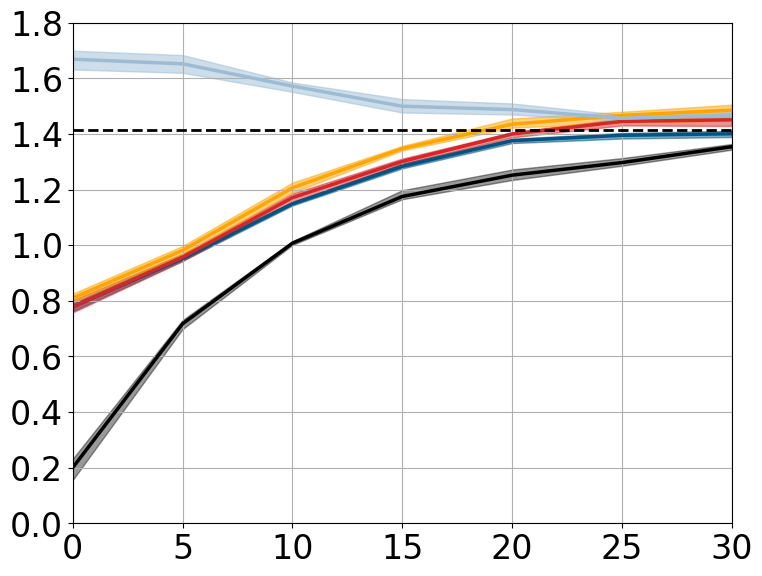

In [18]:
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(1, 1, figsize=(8.5, 6.5))

plot_uncertainty_all(ax, lead_list, np.mean(rmse_19var, axis=0), rmse_19var.T, line_c='black', alpha_fill=0.4)

plot_uncertainty_all(ax, lead_list, np.mean(rmseE1, axis=0), rmseE1.T, line_c='#015482')

line_color = ['tab:red', 'orange', '#9dbcd4']
i = 0
for MD in ['E2', 'E3', 'E4']:
    rmse = np.array([rmse_list[(lead, exp_num, MD)] for lead in lead_list for exp_num in exp_num_list]).reshape(len(lead_list), len(exp_num_list))
    # print(bcc.shape)
    plot_uncertainty_all(ax, lead_list, np.mean(rmse, axis=1), rmse, line_c=line_color[i])
    i += 1

xlim = [0, 30]
ylim = [0.0, 1.8]
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_xticks(np.arange(0, 31, 5))
ax.grid(visible=True)
ax.set_yticks(np.arange(ylim[0], ylim[1]+0.1, 0.2))
ax.plot(xlim, [np.sqrt(2), np.sqrt(2)], 'k--', linewidth=2)